In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip -P data
!unzip -n -d data data/sentiment140-subset.csv.zip

# Load the dataset
df = pd.read_csv("data/sentiment140-subset.csv")
dataset = df[['polarity', 'text']]

--2024-08-07 05:52:47--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/sentiment140-subset.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17927149 (17M) [application/zip]
Saving to: ‘data/sentiment140-subset.csv.zip’

sentiment140-subset 100%[===================>]  17.10M  7.32MB/s    in 2.3s    

2024-08-07 05:52:50 (7.32 MB/s) - ‘data/sentiment140-subset.csv.zip’ saved [17927149/17927149]

Archive:  data/sentiment140-subset.csv.zip
  inflating: data/sentiment140-subset.csv  


In [3]:
# Balance the dataset
minority_count = dataset['polarity'].value_counts().min()
balanced_df = pd.concat([
    dataset[dataset['polarity'] == 0].sample(minority_count, replace=False),
    dataset[dataset['polarity'] == 1].sample(minority_count, replace=False),
]).sample(frac=1).reset_index(drop=True)


In [4]:
# Preprocessing function
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    for tweet in tqdm(textdata, desc="Processing tweets", unit="tweet"):
        tweet = str(tweet).lower()
        tweet = re.sub(urlPattern, ' URL', tweet)
        tweet = re.sub(userPattern, ' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            word = wordLemm.lemmatize(word)
            tweetwords += (word + ' ')
        processedText.append(tweetwords)
    return processedText

processed_text = preprocess(balanced_df['text'].values)


Processing tweets: 100%|██████████| 499450/499450 [00:53<00:00, 9306.99tweet/s]


In [5]:
# Tokenization and padding
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(processed_text)
X = tokenizer.texts_to_sequences(processed_text)
X = pad_sequences(X, maxlen=50)


In [6]:
# Splitting data
Y = balanced_df['polarity'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [7]:
# CNN Model definition
def create_cnn_model(input_length, max_features):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=max_features, output_dim=128, input_length=input_length))

    # Convolutional layers with different filter sizes to capture various patterns
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [8]:
# Create CNN model
cnn_model = create_cnn_model(input_length=X.shape[1], max_features=max_features)

# Model summary
cnn_model.summary()

# Train the CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

history = cnn_model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Evaluate the CNN model
Y_pred = cnn_model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int).flatten()

# Calculate performance metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 169s 30ms/step - accuracy: 0.7449 - loss: 0.5116 - val_accuracy: 0.8014 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 2/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 168s 30ms/step - accuracy: 0.8056 - loss: 0.4273 - val_accuracy: 0.8043 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 3/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 205s 30ms/step - accuracy: 0.8259 - loss: 0.3892 - val_accuracy: 0.8047 - val_loss: 0.4218 - learning_rate: 0.0010
Epoch 5/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.8347 - loss: 0.3745 - val_accuracy: 0.8060 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 6/10
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 200s 29ms/step - accuracy: 0.8388 - loss: 0.3649 - val_accuracy: 0.8058 - val_loss: 0.4254 - learning_rate: 0.0010
3122/3122 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
Accuracy: 0.8095805385924517
Precision: 0.8220471131255588
Recall: 0.79076
F1 Score: 0.8061000846101308


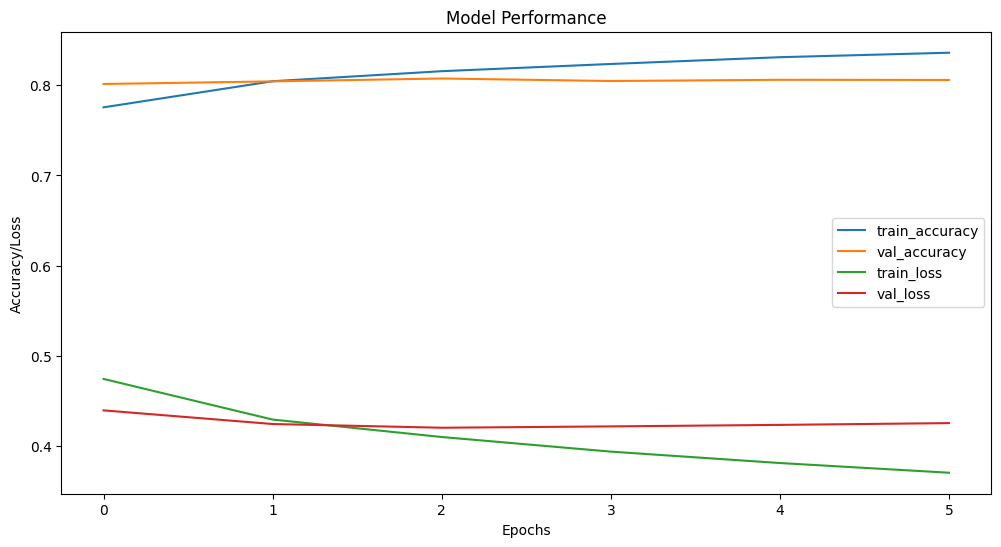

In [9]:
# Plotting model performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

# Another CNN Approach

Explanation of Steps <br/><br/>
Downloading GloVe:<br/> The wget command downloads the GloVe embeddings, which are then extracted from the zip file.

Loading and Preprocessing Data:<br/> The dataset is loaded, balanced, and preprocessed to remove unwanted characters and lemmatize words.

Tokenization and Padding: <br/>The text data is tokenized into sequences, and padding is applied to ensure uniform input size.

Embedding Matrix:<br/> A GloVe embedding matrix is created, allowing for the integration of pre-trained embeddings.
<br/>
CNN Model Architecture:
<br/>
An embedding layer uses the pre-trained GloVe embeddings, which are frozen during training.
Convolutional layers are used to extract features, followed by global max pooling and dropout layers.
A dense layer aggregates features for classification, and a sigmoid activation outputs binary labels.
Training:
<br/>
The model is trained with early stopping and learning rate reduction callbacks, which help avoid overfitting and dynamically adjust the learning rate.
Evaluation:
<br/>
The model's performance is evaluated using metrics like accuracy, precision, recall, and F1-score, providing insight into its effectiveness.

In [18]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import nltk
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove

# Path to the GloVe file
glove_filepath = 'glove/glove.6B.100d.txt'

--2024-08-07 06:29:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-08-07 06:29:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-08-07 06:29:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [20]:
# Load dataset
df = pd.read_csv("data/sentiment140-subset.csv")
dataset = df[['polarity', 'text']]



In [21]:
# Balance the dataset
minority_count = dataset['polarity'].value_counts().min()
balanced_df = pd.concat([
    dataset[dataset['polarity'] == 0].sample(minority_count, replace=False),
    dataset[dataset['polarity'] == 1].sample(minority_count, replace=False),
]).sample(frac=1).reset_index(drop=True)

In [22]:
# Preprocessing function
def preprocess(textdata):
    processedText = []
    wordLemm = WordNetLemmatizer()
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = "[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    for tweet in tqdm(textdata, desc="Processing tweets", unit="tweet"):
        tweet = str(tweet).lower()
        tweet = re.sub(urlPattern, ' URL', tweet)
        tweet = re.sub(userPattern, ' USER', tweet)
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        tweetwords = ''
        for word in tweet.split():
            word = wordLemm.lemmatize(word)
            tweetwords += (word + ' ')
        processedText.append(tweetwords)
    return processedText

processed_text = preprocess(balanced_df['text'].values)

Processing tweets: 100%|██████████| 499450/499450 [00:52<00:00, 9443.69tweet/s]


In [23]:
# Tokenization and padding
max_features = 20000  # Increase vocabulary size
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(processed_text)
X = tokenizer.texts_to_sequences(processed_text)
X = pad_sequences(X, maxlen=100)  # Increase sequence length



In [24]:
# Splitting data
Y = balanced_df['polarity'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [25]:
# Load pre-trained GloVe embeddings
def load_glove_embeddings(filepath, embedding_dim, tokenizer, max_features):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create an embedding matrix
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Define embedding dimension
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_filepath, embedding_dim, tokenizer, max_features)


In [29]:
# CNN Model definition
def create_cnn_model(input_length, max_features, embedding_dim, embedding_matrix):
    model = Sequential()

    # Embedding layer with pre-trained embeddings
    model.add(Embedding(input_dim=max_features,
                        output_dim=embedding_dim,
                        input_length=input_length,
                        weights=[embedding_matrix],
                        trainable=False))  # Freeze embeddings

    # Convolutional layers
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    # Remove GlobalMaxPooling1D layer here
    model.add(Dropout(0.5))  # Dropout layer to reduce overfitting

    # Second convolutional layer
    model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
    model.add(GlobalMaxPooling1D()) # Add GlobalMaxPooling1D after second convolutional layer
    model.add(Dropout(0.5))

    # Fully connected layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [30]:
# Create CNN model with pre-trained embeddings
cnn_model = create_cnn_model(input_length=X.shape[1],
                             max_features=max_features,
                             embedding_dim=embedding_dim,
                             embedding_matrix=embedding_matrix)

# Model summary
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 542s 96ms/step - accuracy: 0.6773 - loss: 0.5918 - val_accuracy: 0.7660 - val_loss: 0.5066 - learning_rate: 0.0010
Epoch 2/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 567s 97ms/step - accuracy: 0.7505 - loss: 0.5149 - val_accuracy: 0.7737 - val_loss: 0.5007 - learning_rate: 0.0010
Epoch 3/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 538s 96ms/step - accuracy: 0.7583 - loss: 0.5018 - val_accuracy: 0.7800 - val_loss: 0.4872 - learning_rate: 0.0010
Epoch 4/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 555s 94ms/step - accuracy: 0.7628 - loss: 0.4959 - val_accuracy: 0.7812 - val_loss: 0.4728 - learning_rate: 0.0010
Epoch 5/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 569s 96ms/step - accuracy: 0.7667 - loss: 0.4911 - val_accuracy: 0.7767 - val_loss: 0.4906 - learning_rate: 0.0010
Epoch 6/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 566s 96ms/step - accuracy: 0.7687 - loss: 0.4869 - val_accuracy: 0.7830 - val_loss: 0.4790 - learning_rate: 0.0010
Epoch 7/15
5619/5619 ━━━━━━━━━━━━━━━━━━━━ 535s 95ms/step -

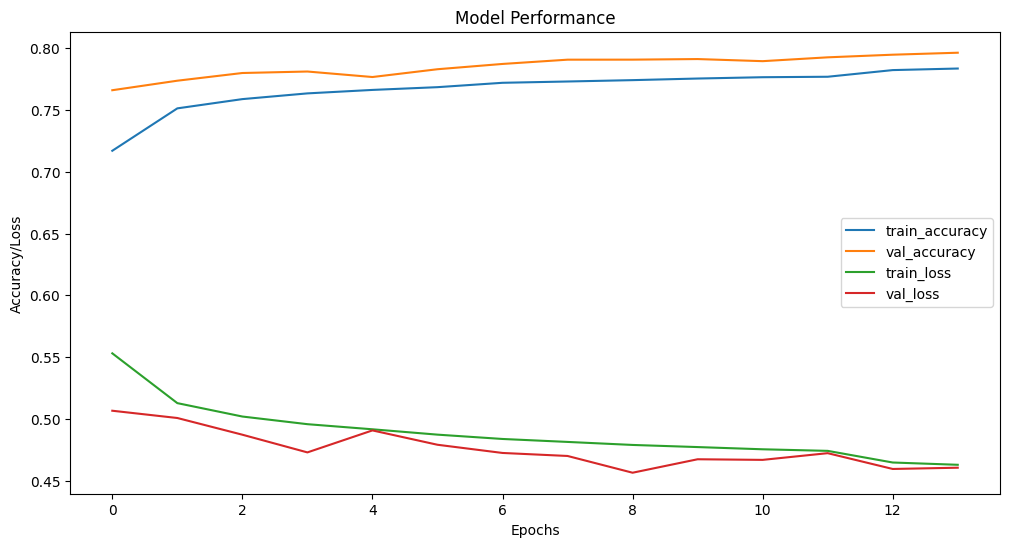

In [31]:
# Train the CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

history = cnn_model.fit(X_train, Y_train, epochs=15, batch_size=64, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# Evaluate the CNN model
Y_pred = cnn_model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int).flatten()

# Calculate performance metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred, average='binary')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plotting model performance
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()
